# An analysis of media images and influence on public opinion polls for presidential candidates

To use this notebook, you will need to get keys to <b>Emotion API</b>. Visit <a href="http://www.projectoxford.ai/emotion">www.projectoxford.ai/emotion</a>, and then the “Try for free” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Emotion API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your key into the variables section below. (Either the primary or the secondary key works.)

### Assumptions
- Ordered by date
    - Then order by site
        - then list average emotion scores

### Issues
- Cannot guarantee the candidate is pictured in the returned image

In [31]:
import time 
import requests
import cv2
import csv
import operator
import numpy as np
import pprint
import json
from lxml import html
from datetime import datetime
from datetime import date, timedelta
from collections import Counter
from googleapiclient.discovery import build
### from watson_developer_cloud import ToneAnalyzerV3

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables

_url        = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_detectUrl  = 'https://api.projectoxford.ai/face/v1.0/detect'
_verifyUrl  = 'https://api.projectoxford.ai/face/v1.0/verify'
_faceKey    = ''  #### PASTE YOUR MICROSOFT FACE API KEY HERE ####
_key        = ''  #### PASTE YOUR MICROSOFT EMOTION API KEY HERE ####
_gKey       = ''  #### PASTE YOUR GOOGLE CUSTOM SEARCH API KEY HERE ####
_cxSources  = '009287171158739071908:f6cgoxrx81s' # Custom Search Engine Using 39 political sites

_maxNumRetries = 3

In [ ]:
### Added this code, but haven't completed the watson-tone-analyzer portion of the code.
### Still a work in progress
tone_analyzer = ToneAnalyzerV3(
   username='YOUR SERVICE USERNAME',
   password='YOUR SERVICE PASSWORD',
   version='2016-05-19 ')

print(json.dumps(tone_analyzer.tone(text='A word is dead when it is said, some say. Emily Dickinson'), indent=2))

## Helper functions

In [4]:
def processEmotionRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = None )

        if response.status_code == 429: 

            print "Message: %s" % ( response.json()['error']['message'] )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print 'Error: failed after retrying!'
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print "Error code: %d" % ( response.status_code )
            print "Message: %s" % ( response.json()['error']['message'] )

        break
        
    return result

In [5]:
def processFaceRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _detectUrl, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [6]:
def processVerifyRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _verifyUrl, json = json, data = data, headers = headers )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [7]:
def renderEmotionResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].iteritems(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

In [8]:
def renderFaceResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 1 )

        faceLandmarks = currFace['faceLandmarks']

        for _, currLandmark in faceLandmarks.items():
            cv2.circle( img, (int(currLandmark['x']),int(currLandmark['y'])), color = (0,255,0), thickness= -1, radius = 1 )

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        faceAttributes = currFace['faceAttributes']

        textToWrite = "%c (%d)" % ( 'M' if faceAttributes['gender']=='male' else 'F', faceAttributes['age'] )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1 )

Function for detecting facai emotion:

### Image Class

In [9]:
class Image:
    def __init__(self, candidate, srcSite, imageURL, imageEmotions, imgWeek, imgDate):
        self.candidate = candidate
        self.site      = srcSite
        self.imageURL  = imageURL
        self.emotions  = imageEmotions
        self.week      = imgWeek 
        self.date      = imgDate
    

In [10]:
def detectEmotion(urlImage):
    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/json' 

    json = { 'url': urlImage } 
    data = None

    result = processEmotionRequest( json, data, headers )
    
    return result

In [11]:
def detectFace(urlImage):
    # Face detection parameters
    params = { 'returnFaceAttributes': 'age,gender', 
               'returnFaceLandmarks': 'true'} 

    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _faceKey
    headers['Content-Type'] = 'application/json' 

    json = { 'url': urlImage }
    data = None

    result = processFaceRequest( json, data, headers, params )
    
    return result


In [12]:
def verifyFace(faceId1, faceId2):
    json   = { 'faceId1': faceId1, 
               'faceId2': faceId2} 
    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _faceKey
    headers['Content-Type'] = 'application/json'
    
    data = None

    result = processVerifyRequest( json, data, headers )
    
    return result
    

In [13]:
def checkDuplicate(newsImage, masterList):
    if not masterList:
        masterList.append(newsImage)
    else:
        for obj in masterList:
            if obj.imageURL == newsImage.imageURL:
                print  "Duplicate Image", obj.imageURL
                break
        else:
            masterList.append(newsImage)
    return masterList

In [14]:
def getEmotions(numOfWeeks, masterList):
    emotionList = ["sadness", "contempt", "disgust", "anger", "surprise", "fear", "happiness", "neutral", "count"]
    masterDict  = dict()

    
    for week in range(1, numOfWeeks + 1):
        siteDict    = dict()
        siteCounter = dict()
        for obj in masterList:
            key = obj.site
            if obj.week == week:
                if key in siteDict:
                    siteCounter[key] += 1
                    siteA = Counter(obj.emotions)
                    siteB = Counter(siteDict[key])
                    sumOfEmotions = siteA + siteB
                    siteDict[key] = sumOfEmotions
                else:
                    siteDict[key] = obj.emotions
                    siteCounter[key] = 1
            else:
                continue
        for key, value in siteDict.iteritems():
            tmpDict = dict()
            for emotion in emotionList:
                if emotion == "count":
                    tmpDict[emotion] = siteCounter[key]
                else:
                    try:
                        currentEmotionScore = siteDict[key][emotion]
                        tmpDict[emotion] = currentEmotionScore / siteCounter[key]
                    except:
                        continue
            siteDict[key] = tmpDict
        masterDict[week] = siteDict
    return masterDict

## Detect faces from an image retrieved via URL
    - For testing only

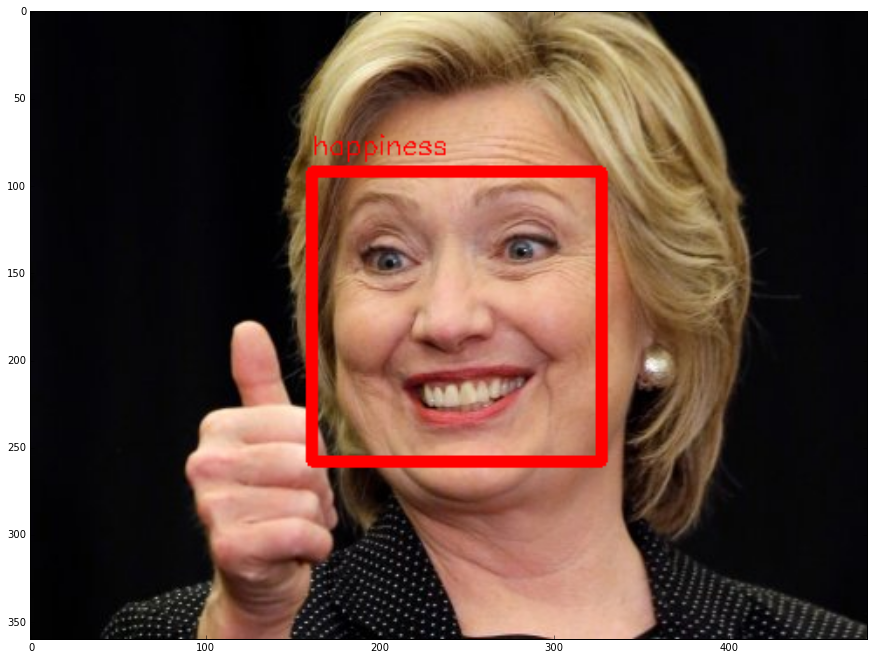

In [454]:
"""   Insert a new url for an image in the urlImage variable or uncomment out the ones I've found
"""

# URL direction to image
#urlImage = 'http://c10.nrostatic.com/sites/default/files/styles/original_image_with_cropping/public/uploaded/donald-trump-grow-up.jpg?itok=n1PW3Myr'
# urlImage = 'http://i.huffpost.com/gen/4364496/thumbs/n-DONALD-TRUMP-large300.jpg'
urlImage = "https://static4.businessinsider.com/image/55fad9869dd7cc15008bb1ba-480/hillary-clinton-thumbs-up.jpg"

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None

result = processRequest( json, data, headers )

# Load the original image, fetched from the URL
arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

renderResultOnImage( result, img )

ig, ax = plt.subplots(figsize=(15, 20))
ax.imshow( img )

In [16]:
service = build("customsearch", "v1", developerKey=_gKey)

# This is the code that pulls it all together

In [521]:
clintonMasterDict = dict()   # Dict by weeek of sites of emotions
sandersMasterDict = dict()
trumpMasterDict   = dict()

clintonMasterList = list()   # Lists of Image class elements for the candidate
sandersMasterList = list()
trumpMasterList   = list()
searchResult      = dict()   # Dictionary to hold the returned JSON search information

startWeek    = 2             ### CHANGE THESE TO CHANGE THE WEEK PERIOD 
endWeek      = 2
numOfWeeks   = 48
numOfResults = 10 * 1        # Must be a multiple of 10, so multiply the number of "pages" by the number of results per page
todayDate    = date.today()  
candidates   = ["Hillary Clinton"] # ["Hillary Clinton", "Bernie Sanders", "Donald Trump"]

service = build("customsearch", "v1", developerKey=_gKey)  

for candidate in candidates:
    for i in range(startWeek, endWeek + 1):
        for j in range(1, numOfResults, 10):
            try:
                searchResult = service.cse().list( q=candidate,               # Query
                                                   # searchType="image",        # Image Search
                                                   imgType="face",            # Face images
                                                   dateRestrict='w' + str(i), # Restrict date by weeks from today
                                                   cx=_cxSources,             # custom search engine
                                                   filter='0',                # do not allow duplicates
                                                   start=j,                   # results "page" to start on
                                                   sort="date:a"              # sort by date ascending
                                                 ).execute()
            except:
                print "Query did not succeed"
                continue
            for k in range(10):
                try:
                    imgSource = searchResult["items"][k]["displayLink"]
                    # imgURL = searchResult["items"][k]["link"]  # This is for Image Search
                    imgURL = searchResult["items"][k]["pagemap"]["cse_image"][0]["src"]  # This is for default search
                    weekPublished = numOfWeeks - i
                    datePublished = todayDate - timedelta(days=(i * 7))
                    results = detectEmotion(imgURL)
                    time.sleep(6)    # MS API only allows 10 requests per minute, per my testing.
                except:      # if there is an error trying to get any on the needed data, skip the search result
                    print "Search Result was missing an image"
                    continue            

                if not results:
                    print "Failed to find a face in the image"
                    continue
                try:
                    emotionScores = results[0]["scores"]
                except:    
                    # emotionScores = results[0][0]["scores"]
                    print "Image has more than one face"
                
                newsImage = Image(candidate, imgSource, imgURL, emotionScores, weekPublished, datePublished)
                if candidate == "Hillary Clinton":
                    clintonMasterList = checkDuplicate(newsImage, clintonMasterList)                            
                if candidate ==  "Bernie Sanders":
                    sandersMasterList = checkDuplicate(newsImage, sandersMasterList)
                if candidate ==  "Donald Trump":
                    trumpMasterList = checkDuplicate(newsImage, trumpMasterList)
    
    # Write out all the data from the candidates list
    masterList = [clintonMasterList, sandersMasterList, trumpMasterList]
    outFile = '' + candidate + "_full_output.csv"
    csvFile = open(outFile, 'a')
    headerString = 'week, date, website, count, sadness, contempt, disgust, anger, surprise, fear, happiness, neutral, imageUrl\n'
    csvFile.write(headerString)
    for imageList in masterList:
        for image in imageList:
            weekAsDate = image.date.strftime('%m/%d/%Y') 
            count          = 1
            sadnessScore   = image.emotions["sadness"]
            contemptScore  = image.emotions["contempt"]
            disgustScore   = image.emotions["disgust"]
            angerScore     = image.emotions["anger"]
            surpriseScore  = image.emotions["surprise"]
            fearScore      = image.emotions["fear"]
            happinessScore = image.emotions["happiness"]
            neutralScore   = image.emotions["neutral"]
            emotionScoreString = '' + str(count) + ',' + \
                                      str(sadnessScore)   + ',' + str(contemptScore) + ',' + str(disgustScore) + ',' + \
                                      str(angerScore)     + ',' + str(surpriseScore) + ',' + str(fearScore)    + ',' + \
                                      str(happinessScore) + ',' + str(neutralScore) 
            writeString = '' + str(image.week) + ',' + weekAsDate + ',' + image.site + ',' + emotionScoreString + ',' + image.imageURL + '\n'
            csvFile.write(writeString)
    csvFile.close()            
    # <candidate>MasterDict will be a dict of {week# : {website : { emotion: emotionScore}}}
    if candidate ==  "Hillary Clinton":
        clintonMasterDict = getEmotions(numOfWeeks, clintonMasterList)
    if candidate ==  "Bernie Sanders":
        sandersMasterDict = getEmotions(numOfWeeks, sandersMasterList)
    if candidate ==  "Donald Trump":
        trumpMasterDict = getEmotions(numOfWeeks, trumpMasterList)
    
    masterDictList = [clintonMasterDict, sandersMasterDict, trumpMasterDict]
    # Write out to a csv file        
    outFile = '' + candidate + "_output.csv"
    csvFile = open(outFile, 'a')
    headerString = 'week, date, website, count, sadness, contempt, disgust, anger, surprise, fear, happiness, neutral\n'
    csvFile.write(headerString)
    for candidateDict in masterDictList:
        for week, valueDict in candidateDict.iteritems():
            weekAsDate = todayDate - timedelta(days=((numOfWeeks - week) * 7)) 
            weekAsDate = weekAsDate.strftime('%m/%d/%Y') 
            emotionScoreString = ''
            for site, emotionDict in valueDict.iteritems():
                count          = emotionDict["count"]
                sadnessScore   = emotionDict["sadness"]
                contemptScore  = emotionDict["contempt"]
                disgustScore   = emotionDict["disgust"]
                angerScore     = emotionDict["anger"]
                surpriseScore  = emotionDict["surprise"]
                fearScore      = emotionDict["fear"]
                happinessScore = emotionDict["happiness"]
                neutralScore   = emotionDict["neutral"]
                emotionScoreString = '' + str(count) + ',' + \
                                          str(sadnessScore)   + ',' + str(contemptScore) + ',' + str(disgustScore) + ',' + \
                                          str(angerScore)     + ',' + str(surpriseScore) + ',' + str(fearScore)    + ',' + \
                                          str(happinessScore) + ',' + str(neutralScore) 
                writeString = '' + str(week) + ',' + weekAsDate + ',' + site + ',' + emotionScoreString + '\n'
                csvFile.write(writeString)
    csvFile.close()
print "Script Completed"

Failed to find a face in the image
Failed to find a face in the image
Search Result was missing an image
Search Result was missing an image
Failed to find a face in the image
Script Completed


### Detecting a Face and Verifying that it is the specified candidate that we searched for

In [35]:
# Hillary Clinton's Face ID:
hillaryImage = 'http://i.huffpost.com/gen/2942842/images/o-HILLARY-CLINTON-facebook.jpg'
results = detectFace(hillaryImage)
time.sleep(3)
clintonFaceId = results[0]["faceId"]

# Bernie Sanders Face ID:
bernieImage  = 'http://www.gannett-cdn.com/-mm-/f879a8b913f18f6bde45e56ce3936ebca696bd89/c=0-235-4926-3018&r=x1683&c=3200x1680/local/-/media/2015/06/09/USATODAY/USATODAY/635694650061186432-XXX-CAPITAL-DOWNLOAD-SEN.-SANDERS-JMG-39235-73667404.JPG'
results = detectFace(bernieImage)
time.sleep(3)
sandersFaceId = results[0]["faceId"]

# Donald Trump Face ID:
donaldImage  = 'https://pmcdeadline2.files.wordpress.com/2015/06/donald-trump.jpg'
results = detectFace(donaldImage)
time.sleep(3)
trumpFaceId = results[0]["faceId"]

In [36]:
print "ClintonID = " + clintonFaceId
print "SandersID = " + sandersFaceId
print "TrumpID = "   + trumpFaceId

ClintonID = 5bf95f9c-c94a-4b20-a0f6-89a5f5166473
SandersID = 7afe1500-4127-42a4-9cc9-215de1a3458c
TrumpID = de0c45f9-1a4c-4193-a10f-a48457c540c6


In [53]:
# clintonFaceId = "5bf95f9c-c94a-4b20-a0f6-89a5f5166473"
# sandersFaceId = "7afe1500-4127-42a4-9cc9-215de1a3458c"
# trumpFaceId   = "de0c45f9-1a4c-4193-a10f-a48457c540c6"

columnHeader = 'week,date,website,count,sadness,contempt,disgust,anger,surprise,fear,happiness,neutral,confidence,imageUrl\n'

candidates   = {"Hillary Clinton" : clintonFaceId, "Bernie Sanders" : sandersFaceId, "Donald Trump" : trumpFaceId}
for candidate, candidateFaceId in candidates.iteritems():    
    # Read in a csv file        
    inFile = '' + candidate + "_full.csv"
    outFile = '' + candidate + "_with_confidence.csv"
    with open(inFile, 'rb') as csvFile, open(outFile, 'wb') as csvOutFile:
        csvReader = csv.reader(csvFile)
        csvWriter = csv.writer(csvOutFile)
        
        for row in csvReader:
            if row[0] == "week":
                continue
            week      = row[0]
            date      = row[1]
            website   = row[2]
            count     = row[3]
            sadness   = row[4]
            contempt  = row[5]
            disgust   = row[6]
            anger     = row[7]
            surprise  = row[8]
            fear      = row[9]
            happiness = row[10]
            neutral   = row[11]
            imageUrl  = row[12]
            
            results = detectFace(imageUrl)
            time.sleep(6)
            if not results:
                confidence = 0.0
            else:
                compareFaceId = results[0]["faceId"]
                results = verifyFace(candidateFaceId, compareFaceId)
                confidence = results["confidence"]
            print candidate, confidence, imageUrl
            
            csvWriter.writerow( (week, date, website, count, sadness, contempt, disgust, anger, surprise
                                ,fear, happiness, neutral, confidence, imageUrl) )
            
            
            
            

Donald Trump 0.11933 http://media4.s-nbcnews.com/j/newscms/2016_24/1585361/160618-elizabeth-warren-senate-408p_6d1c03d08e5e29ff86ba4397caed4019.nbcnews-fp-1200-800.jpg
Donald Trump 0.14863 http://i2.cdn.turner.com/cnnnext/dam/assets/160617135352-elizabeth-warren-june-9-2016-large-tease.jpg
Donald Trump 0.12427 http://assets.bwbx.io/images/users/iqjWHBFdfxIU/iHU1M_FCrsB4/v0/220x220.jpg
Donald Trump 0.20671 http://img.huffingtonpost.com/asset/2000_1000/5765df511500002b0073b4f9.png?cache=zyxicurzd5
Donald Trump 0.47252 http://i2.cdn.turner.com/cnnnext/dam/assets/160618073134-donald-trump-june-16-2016-large-tease.jpg
Donald Trump 0.19341 http://img.huffingtonpost.com/asset/2000_1000/5765a4c71500002a0073b4c7.jpeg?cache=cy21sxokyc
Donald Trump 0.60112 http://cbsnews1.cbsistatic.com/hub/i/r/2016/06/18/8c6a4cae-5271-422b-a96b-67a575e9fce3/thumbnail/1200x630/e801978586e1697d9b80fc562dd514dd/0618engoldmantrump1080861640x360.jpg
Donald Trump 0.5963 http://media3.s-nbcnews.com/j/newscms/2016_24/15